# Dataset Downloading


In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'the-fake-or-real-dataset' dataset.
Path to dataset files: /kaggle/input/the-fake-or-real-dataset


#Data Preprocessing

**ขั้นตอนที่ 1 : ทำความสะอาดข้อมูล**  

      ลบไฟล์ที่มีขนาด 0 ไบต์ ลบไฟล์เสียงที่ว่างหรือไฟล์เสีย
      ลบไฟล์ที่ซ้ำกัน
      โหลดและเติมสัญญาณให้ครบ 16,000 Sampling Rate (มาตรฐานที่เหมาะสมสำหรับประมวลผลเสียงพูด)

In [21]:
import os
import librosa
import numpy as np
import hashlib
from tqdm import tqdm

#ลบไฟล์ที่ซ้ำกัน
def compute_md5(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

#โหลดไฟล์เสียงและปรับความยาวให้เป็น 1 วินาที (16,000 samples)
def load_and_pad(file_path, sr=16000):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        if len(y) < sr:
            y = np.pad(y, (0, sr - len(y)))
        return y
    except:
        return None

#ทำความสะอาดข้อมูล, และประมวลผลไฟล์เสียงทั้งหมดก่อนนำไปใช้กับโมเดล
def preprocess_audio_dir(base_path):
    all_audio = []
    all_labels = []
    seen_hashes = set()

    for label_name in ['real', 'fake']:
        label_dir = os.path.join(base_path, label_name)
        label = 0 if label_name == 'real' else 1

        for file in tqdm(os.listdir(label_dir), desc=f"Processing {label_name}"):
            path = os.path.join(label_dir, file)
            if os.path.getsize(path) == 0:
                continue
            file_hash = compute_md5(path)
            if file_hash in seen_hashes:
                continue
            seen_hashes.add(file_hash)

            y = load_and_pad(path)
            if y is None:
                continue

            all_audio.append(y)
            all_labels.append(label)

    return all_audio, all_labels

**ขั้นตอนที่ 2 : Feature Extraction (MFCC + Standardization)**

    สกัด MFCCs(Mel-Frequency Cepstral Coefficients) จากข้อมูลเสียง
    ปรับขนาดข้อมูล(Standardization)

In [22]:
from sklearn.preprocessing import StandardScaler

def extract_mfcc_features(audio_list, sr=16000, n_mfcc=40):
    mfcc_features = []
    for y in tqdm(audio_list, desc="Extracting MFCCs"):
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_mean)
    return np.array(mfcc_features)

def normalize_features(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, scaler

# Machine Learning

**ขั้นตอนที่ 1 : ฝึกฝนโมเดล Machine Learning**  

      ฝึกฝนโมเดล Machine Learning หลายตัวพร้อมกัน โดยใช้ชุดข้อมูลที่เตรียมไว้แล้ว

In [43]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def train_models(X_train, y_train):
    models = {"SVM": SVC(probability=True),
              "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),}

    trained = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained[name] = model
    return trained

**Evaluate on Datasets**


In [44]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {"accuracy": acc,
                         "precision": report['weighted avg']['precision'],
                         "recall": report['weighted avg']['recall'],
                         "f1": report['weighted avg']['f1-score']}
    return results

**Compare All Models Across Datasets**

In [45]:
import pandas as pd
import joblib

#Dataset paths
dataset_dirs = {"rerec": "/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded"}

#def compare_all_datasets(dataset_dirs, base_path):
all_results = {}

for name, dataset_dir in dataset_dirs.items():
    train_path = os.path.join(dataset_dir, 'training')
    val_path = os.path.join(dataset_dir, 'validation')
    test_path = os.path.join(dataset_dir, 'testing')

    global y_train
    global y_test
    X_train_raw, y_train = preprocess_audio_dir(train_path)
    X_val_raw, y_val = preprocess_audio_dir(val_path)
    X_test_raw, y_test = preprocess_audio_dir(test_path)

    global X_train
    global X_test
    X_train = extract_mfcc_features(X_train_raw)
    X_val = extract_mfcc_features(X_val_raw)
    X_test = extract_mfcc_features(X_test_raw)

    X_train, X_val, X_test, _ = normalize_features(X_train, X_val, X_test)
    global models
    models = train_models(X_train, y_train)

    #Save each model to disk
    for model_name, model in models.items():
        filename = f"{name}_{model_name.replace(' ', '_')}.pkl"
        joblib.dump(model, filename)
        print(f"Saved model: {filename}")

    results = evaluate_models(models, X_test, y_test)
    all_results[name] = results

results = all_results

# Print as DataFrame
final_df = pd.DataFrame({ds: res for ds, res in results.items()}).T
display(final_df)

Extracting MFCCs: 100%|██████████| 816/816 [00:07<00:00, 110.76it/s]


Saved model: rerec_SVM.pkl
Saved model: rerec_MLP.pkl


,SVM,MLP
rerec,"{'accuracy': 0.7818627450980392, 'precision': ...","{'accuracy': 0.8480392156862745, 'precision': ..."


In [46]:
# Flatten nested dictionary into a long-form DataFrame
flat_results = []

for dataset, model_metrics in results.items():
    for model_name, metrics in model_metrics.items():
        result_row = {"Dataset": dataset,
                      "Model": model_name,
                      "Accuracy": metrics["accuracy"],
                      "Precision": metrics["precision"],
                      "Recall": metrics["recall"],
                      "F1 Score": metrics["f1"]}
        flat_results.append(result_row)

# Save and display the results
results_df = pd.DataFrame(flat_results)
results_df.to_csv("model_evaluation_results.csv", index=False)

print("Model Evaluation Results:")
display(results_df)

Model Evaluation Results:


,Dataset,Model,Accuracy,Precision,Recall,F1 Score
0,rerec,SVM,0.781863,0.844524,0.781863,0.771472
1,rerec,MLP,0.848039,0.872225,0.848039,0.845530


In [27]:
import joblib
import numpy as np

#Load trained MLP model
mlp = joblib.load("rerec_MLP.pkl")

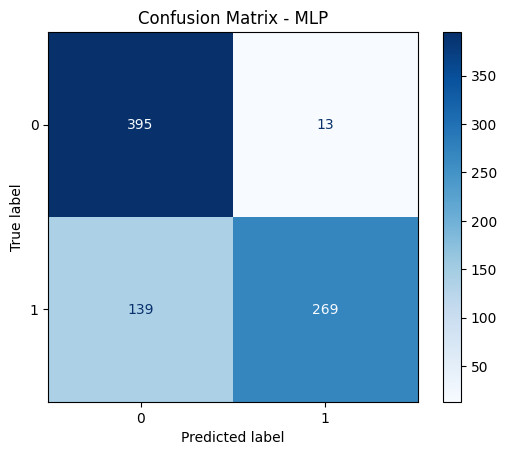

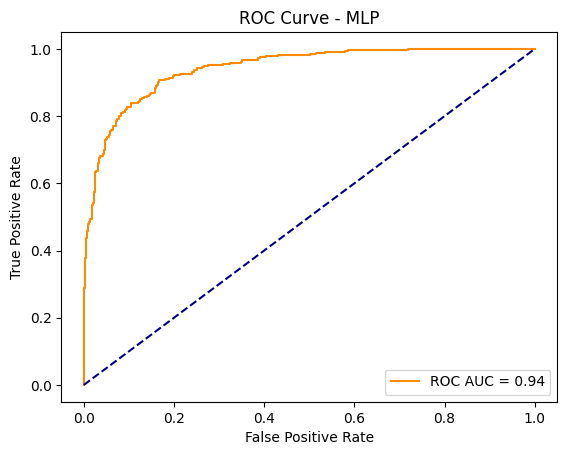

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import os

os.makedirs("results", exist_ok=True)

y_true = y_test
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - MLP")
plt.savefig("results/confusion_matrix.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP")
plt.legend()
plt.savefig("results/roc_curve.png")
plt.show()


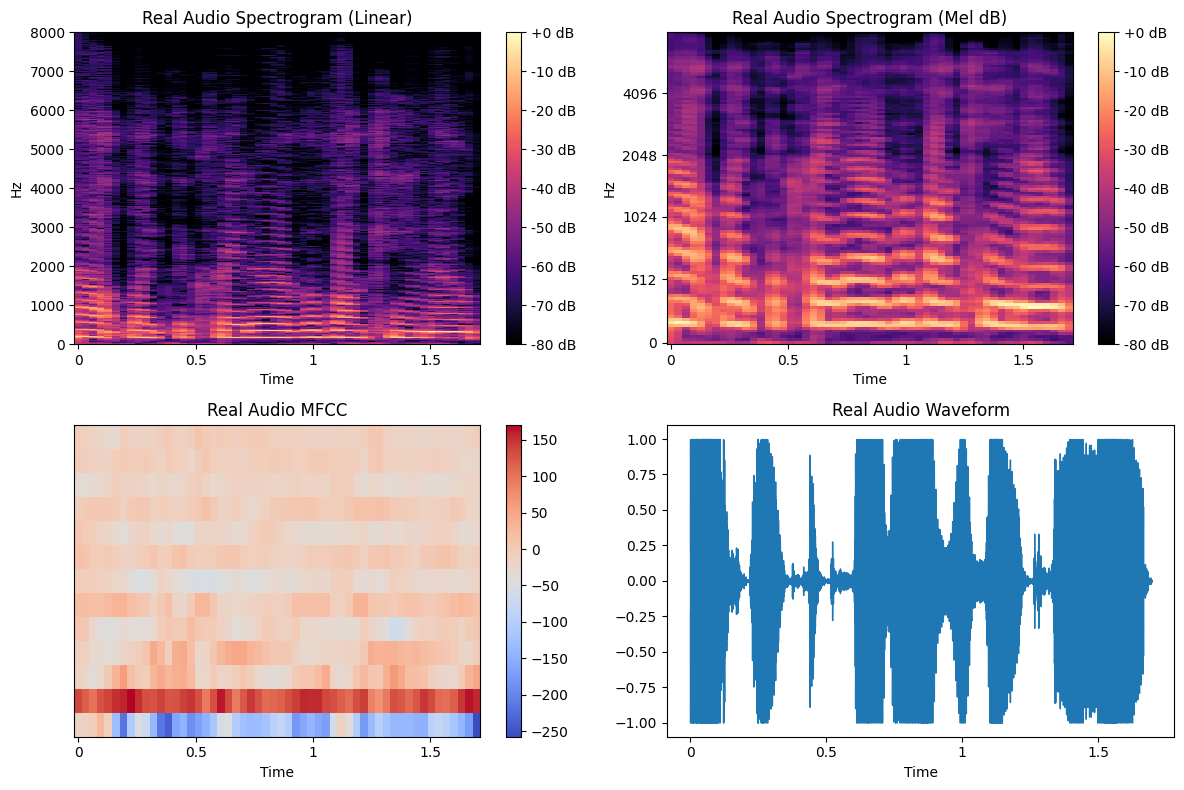

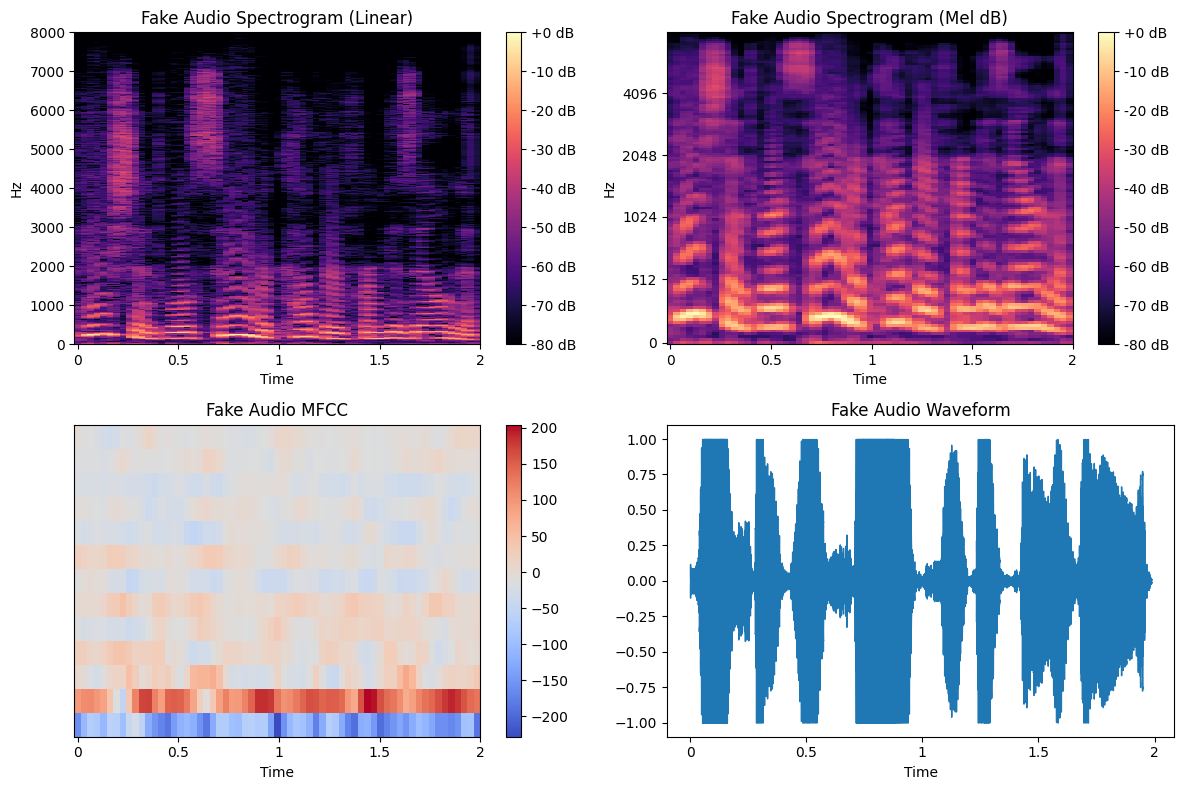

In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_spectrograms(audio_path, title_prefix=''):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)

    # Compute spectrogram (linear)
    D = np.abs(librosa.stft(y))

    # Convert to dB scale
    DB = librosa.amplitude_to_db(D, ref=np.max)

    # Compute log-mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spect, ref=np.max)

    # Plot
    plt.figure(figsize=(12, 8))

    # Linear spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='linear')
    plt.title(f'{title_prefix} Spectrogram (Linear)')
    plt.colorbar(format='%+2.0f dB')

    # Log-mel spectrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f'{title_prefix} Spectrogram (Mel dB)')
    plt.colorbar(format='%+2.0f dB')

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.subplot(2, 2, 3)
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.title(f'{title_prefix} MFCC')
    plt.colorbar()

    # Waveform
    plt.subplot(2, 2, 4)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'{title_prefix} Waveform')

    plt.tight_layout()
    plt.show()

plot_audio_spectrograms("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/real/recording13532.wav_norm_mono.wav", title_prefix="Real Audio")
plot_audio_spectrograms("/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/fake/recording13014.wav_norm_mono.wav", title_prefix="Fake Audio")



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

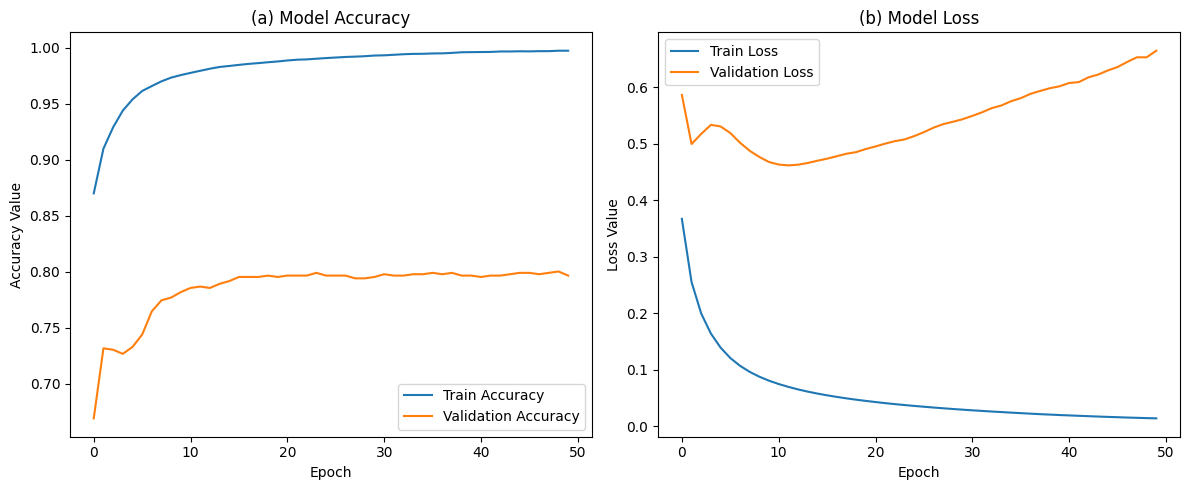

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelBinarizer

# Initialize model with warm_start=True to continue training over epochs
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42)

# Prepare one-hot labels for log loss
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Lists to store accuracy and loss values
train_acc, val_acc = [], []
train_loss, val_loss = [], []

n_epochs = 50

for epoch in range(n_epochs):
    model.fit(X_train, y_train)  # Continues training from previous weights

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Accuracy
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_test, y_test_pred))

    # Loss
    train_loss.append(log_loss(y_train_bin, y_train_proba))
    val_loss.append(log_loss(y_test_bin, y_test_proba))

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("(a) Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("(b) Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()

plt.tight_layout()
plt.show()


# Hyper Paramterization

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import pandas as pd
import joblib

#Dataset paths
dataset_dirs = {"rerec": "/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded"}

#def compare_all_datasets(dataset_dirs, base_path):
all_results = []

for name, dataset_dir in dataset_dirs.items():
    train_path = os.path.join(dataset_dir, 'training')
    val_path = os.path.join(dataset_dir, 'validation')
    test_path = os.path.join(dataset_dir, 'testing')

    X_train_raw, y_train = preprocess_audio_dir(train_path)
    X_val_raw, y_val = preprocess_audio_dir(val_path)
    X_test_raw, y_test = preprocess_audio_dir(test_path)

    X_train = extract_mfcc_features(X_train_raw)
    X_val = extract_mfcc_features(X_val_raw)
    X_test = extract_mfcc_features(X_test_raw)

    X_train, X_val, X_test, _ = normalize_features(X_train, X_val, X_test)

    param_dist = {'hidden_layer_sizes': [(128,), (64, 32), (128, 64, 32)],
                  'activation': ['relu', 'tanh'],
                  'solver': ['adam'],
                  'alpha': uniform(1e-5, 1e-2),  # L2 regularization
                  'learning_rate_init': uniform(1e-4, 1e-2),
                  'batch_size': [32, 64, 128],
                  'learning_rate': ['constant', 'adaptive'],
                  'max_iter': [500]}

    mlp = MLPClassifier(random_state=42)

    random_search = RandomizedSearchCV(mlp,
                                       param_distributions=param_dist,
                                       n_iter=30,
                                       cv=3,
                                       scoring='accuracy',
                                       n_jobs=-1,
                                       verbose=2)

    random_search.fit(X_train, y_train)
    print("Best params:", random_search.best_params_)
    y_pred = random_search.best_estimator_.predict(X_test)

    # Calculate accuracy
    from sklearn.metrics import accuracy_score
    test_accuracy = accuracy_score(y_test, y_pred)

    print("Test accuracy:", test_accuracy)
    all_results.append([name,test_accuracy])

Extracting MFCCs: 100%|██████████| 816/816 [00:07<00:00, 116.45it/s]


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'activation': 'relu', 'alpha': np.float64(0.009306718146497021), 'batch_size': 128, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.008731908734319943), 'max_iter': 500, 'solver': 'adam'}
Test accuracy: 0.8100490196078431


In [48]:
print("Best params:", random_search.best_params_)

Best params: {'activation': 'relu', 'alpha': np.float64(0.009306718146497021), 'batch_size': 128, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.008731908734319943), 'max_iter': 500, 'solver': 'adam'}


In [49]:
# Predict on test data
y_pred = random_search.best_estimator_.predict(X_test)

# Calculate accuracy
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, y_pred)

print("Test accuracy:", test_accuracy)

Test accuracy: 0.8100490196078431


# Deep Learning

In [34]:
import os
import librosa
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import joblib

# Preprocessing functions (reusing your existing code)
def compute_md5(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def load_and_pad(file_path, sr=16000):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        if len(y) < sr:
            y = np.pad(y, (0, sr - len(y)))
        return y
    except:
        return None

def preprocess_audio_dir(base_path):
    all_audio = []
    all_labels = []
    seen_hashes = set()
    for label_name in ['real', 'fake']:
        label_dir = os.path.join(base_path, label_name)
        label = 0 if label_name == 'real' else 1
        for file in tqdm(os.listdir(label_dir), desc=f"Processing {label_name}"):
            path = os.path.join(label_dir, file)
            if os.path.getsize(path) == 0:
                continue
            file_hash = compute_md5(path)
            if file_hash in seen_hashes:
                continue
            seen_hashes.add(file_hash)
            y = load_and_pad(path)
            if y is None:
                continue
            all_audio.append(y)
            all_labels.append(label)
    return all_audio, all_labels

# Enhanced feature extraction for deep learning (generating spectrograms)
def extract_mfcc_spectrograms(audio_list, sr=16000, n_mfcc=40):
    """Extract MFCC spectrograms for deep learning models"""
    spectrograms = []
    for y in tqdm(audio_list, desc="Extracting MFCC Spectrograms"):
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Normalize mfcc features per audio file
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-8)
        # Pad or trim to fixed size (e.g., 40 x 64)
        if mfcc.shape[1] < 64:
            pad_width = 64 - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :64]
        spectrograms.append(mfcc)

    # Convert to numpy array and reshape for CNN (add channel dimension)
    spectrograms = np.array(spectrograms)
    spectrograms = np.expand_dims(spectrograms, axis=-1)  # Shape: (n_samples, n_mfcc, time_steps, 1)
    return spectrograms

# Create VGG16-based model for deepfake detection
def create_vgg16_model(input_shape):
    """Create a VGG16-based transfer learning model"""
    # Create a base model from VGG16 without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create new model
    inputs = Input(shape=input_shape)

    # Convert grayscale to 3-channel (if input is grayscale)
    if input_shape[-1] == 1:
        x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(inputs)
    else:
        x = inputs

    # Resize to 64x64 if needed
    x = tf.keras.layers.Resizing(64, 64)(x)

    # Pass through the VGG16 model
    x = base_model(x)

    # Add classification layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create LSTM model for deepfake detection
def create_lstm_model(input_shape):
    """Create an LSTM model for MFCC sequence analysis"""
    # Reshape input to be suitable for LSTM (samples, time steps, features)
    lstm_input_shape = (input_shape[1], input_shape[0])  # (time_steps, features)

    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Reshape(lstm_input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Data preparation for VGG16
def prepare_data_for_dl(X_spectrograms, y_labels):
    """Prepare data for deep learning models"""
    # Convert labels to categorical
    y_categorical = to_categorical(y_labels, num_classes=2)

    return X_spectrograms, y_categorical

# Main execution
if __name__ == "__main__":
    # Dataset paths (reusing your paths)
    dataset_dirs = {"rerec": "/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded"}

    all_results = {}

    for name, dataset_dir in dataset_dirs.items():
        print(f"Processing dataset: {name}")

        # Load data from directories
        train_path = os.path.join(dataset_dir, 'training')
        val_path = os.path.join(dataset_dir, 'validation')
        test_path = os.path.join(dataset_dir, 'testing')

        X_train_raw, y_train = preprocess_audio_dir(train_path)
        X_val_raw, y_val = preprocess_audio_dir(val_path)
        X_test_raw, y_test = preprocess_audio_dir(test_path)

        # Extract MFCC spectrograms for deep learning
        X_train_spectrograms = extract_mfcc_spectrograms(X_train_raw)
        X_val_spectrograms = extract_mfcc_spectrograms(X_val_raw)
        X_test_spectrograms = extract_mfcc_spectrograms(X_test_raw)

        # Prepare data for deep learning
        X_train_dl, y_train_dl = prepare_data_for_dl(X_train_spectrograms, y_train)
        X_val_dl, y_val_dl = prepare_data_for_dl(X_val_spectrograms, y_val)
        X_test_dl, y_test_dl = prepare_data_for_dl(X_test_spectrograms, y_test)

Processing dataset: rerec


Extracting MFCC Spectrograms: 100%|██████████| 816/816 [00:05<00:00, 162.99it/s]


In [35]:
        # Set up callbacks
        checkpoint_vgg = ModelCheckpoint(
            f"{name}_vgg16_model.keras",  # Using the .keras extension
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        checkpoint_lstm = ModelCheckpoint(
            f"{name}_lstm_model.keras",  # Change this extension too
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Create and train VGG16 model
        print("Training VGG16 model...")
        input_shape = X_train_spectrograms.shape[1:]
        vgg16_model = create_vgg16_model(input_shape)

        vgg16_history = vgg16_model.fit(
            X_train_dl,
            y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=32,
            callbacks=[checkpoint_vgg, early_stopping]
        )

        # Create and train LSTM model
        print("Training LSTM model...")
        lstm_model = create_lstm_model(input_shape)

        lstm_history = lstm_model.fit(
            X_train_dl,
            y_train_dl,
            validation_data=(X_val_dl, y_val_dl),
            epochs=20,
            batch_size=32,
            callbacks=[checkpoint_lstm, early_stopping]
        )

        # Evaluate models
        vgg16_eval = vgg16_model.evaluate(X_test_dl, y_test_dl)
        lstm_eval = lstm_model.evaluate(X_test_dl, y_test_dl)

        # Get predictions
        vgg16_pred = np.argmax(vgg16_model.predict(X_test_dl), axis=1)
        lstm_pred = np.argmax(lstm_model.predict(X_test_dl), axis=1)
        y_test_classes = np.argmax(y_test_dl, axis=1)

        # Calculate metrics
        vgg16_accuracy = accuracy_score(y_test_classes, vgg16_pred)
        lstm_accuracy = accuracy_score(y_test_classes, lstm_pred)

        vgg16_report = classification_report(y_test_classes, vgg16_pred, output_dict=True)
        lstm_report = classification_report(y_test_classes, lstm_pred, output_dict=True)

        # Store results
        results = {
            "VGG16": {
                "accuracy": vgg16_accuracy,
                "precision": vgg16_report['weighted avg']['precision'],
                "recall": vgg16_report['weighted avg']['recall'],
                "f1": vgg16_report['weighted avg']['f1-score']
            },
            "LSTM": {
                "accuracy": lstm_accuracy,
                "precision": lstm_report['weighted avg']['precision'],
                "recall": lstm_report['weighted avg']['recall'],
                "f1": lstm_report['weighted avg']['f1-score']
            }
        }

        all_results[name] = results

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
        plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'VGG16 Model Accuracy - {name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
        plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'LSTM Model Accuracy - {name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{name}_training_history.png")
        plt.close()

        # Plot confusion matrices
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        vgg16_cm = confusion_matrix(y_test_classes, vgg16_pred)
        plt.imshow(vgg16_cm, cmap='Blues')
        plt.title(f'VGG16 Confusion Matrix - {name}')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks([0, 1], ['Real', 'Fake'])
        plt.yticks([0, 1], ['Real', 'Fake'])

        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{vgg16_cm[i, j]}", ha='center', va='center')

        plt.subplot(1, 2, 2)
        lstm_cm = confusion_matrix(y_test_classes, lstm_pred)
        plt.imshow(lstm_cm, cmap='Blues')
        plt.title(f'LSTM Confusion Matrix - {name}')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks([0, 1], ['Real', 'Fake'])
        plt.yticks([0, 1], ['Real', 'Fake'])

        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{lstm_cm[i, j]}", ha='center', va='center')

        plt.tight_layout()
        plt.savefig(f"{name}_confusion_matrices.png")
        plt.close()

    # Print final results as DataFrame
print("\nFinal results:")
final_df = pd.DataFrame({ds: res for ds, res in all_results.items()}).T
print(final_df)

Training VGG16 model...
Epoch 1/20
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7625 - loss: 0.4990
Epoch 1: val_accuracy improved from -inf to 0.84046, saving model to rerec_vgg16_model.keras
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7627 - loss: 0.4986 - val_accuracy: 0.8405 - val_loss: 0.3593
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8389 - loss: 0.3575
Epoch 2: val_accuracy improved from 0.84046 to 0.85383, saving model to rerec_vgg16_model.keras
319/319 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8389 - loss: 0.3575 - val_accuracy: 0.8538 - val_loss: 0.3277
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8497 - loss: 0.3308
Epoch 3: val_accuracy improved from 0.85383 to 0.86854, saving model to rerec_vgg16_model.keras
319/319 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8497 - loss: 0.3308 - val_accuracy: 0.8685 - val_loss: 0.2872
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8738 -

In [36]:
# Print final results in a more readable format
print("\nFinal results:")
for dataset_name, models in all_results.items():
    print(f"\nDataset: {dataset_name}")
    for model_name, metrics in models.items():
        print(f"  {model_name} model:")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value:.4f}")


Final results:

Dataset: rerec
  VGG16 model:
    accuracy: 0.7941
    precision: 0.8053
    recall: 0.7941
    f1: 0.7922
  LSTM model:
    accuracy: 0.7708
    precision: 0.7751
    recall: 0.7708
    f1: 0.7699
